<a href="https://colab.research.google.com/github/realdarter/Dart_Website/blob/main/GPTPretrained_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import math
import numpy as np
import pandas as pd
from sklearn import model_selection
import re
print(tf.__version__)

from google.colab import files

# Upload your kaggle.json file
#uploaded = files.upload()

#!mkdir -p ~/.kaggle
#!mv kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d hijest/cleaned-data-for-the-chatbot-collected-from-movies

# Unzip the dataset
!unzip cleaned-data-for-the-chatbot-collected-from-movies.zip



2.15.0
Dataset URL: https://www.kaggle.com/datasets/hijest/cleaned-data-for-the-chatbot-collected-from-movies
License(s): copyright-authors
cleaned-data-for-the-chatbot-collected-from-movies.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  cleaned-data-for-the-chatbot-collected-from-movies.zip
replace dialogs_expanded.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace input3.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace model_att29iter_expanded.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace model_att29iter_expanded.index? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace target3.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [7]:
# Read the dataset
data_df = pd.read_csv("dialogs_expanded.csv", index_col=False)
data_df = data_df.sample(frac=0.1) #fractional trained here
print("Number of elements in features:", data_df.count())

# Combine question and answer for training
data_df['text'] = data_df['question'] + " " + data_df['answer']

Number of elements in features: Unnamed: 0         13941
question           13941
answer             13941
question_as_int    13941
answer_as_int      13941
question_len       13941
answer_len         13941
dtype: int64


In [3]:
!pip install datasets
!pip install accelerate -U

In [4]:
!pip install accelerate>=0.21.0
!pip install transformers[torch]

In [5]:
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel, Trainer, TrainingArguments
from datasets import Dataset

In [8]:



# Convert the DataFrame to a Dataset object
dataset = Dataset.from_pandas(data_df[['text']])

# Load pre-trained tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Set the pad token
tokenizer.pad_token = tokenizer.eos_token

# Tokenize the dataset
def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format("torch")

model = GPT2LMHeadModel.from_pretrained('gpt2')

class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs):
        labels = inputs["input_ids"]
        outputs = model(**inputs, labels=labels)
        return outputs.loss

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',  # directory for storing logs
    logging_steps=10,
)

from transformers import TrainerCallback

# Custom callback to log training and validation loss
class LoggingCallback(TrainerCallback):
    def __init__(self):
        self.training_loss = []
        self.validation_loss = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if 'loss' in logs:
            self.training_loss.append(logs['loss'])
        if 'eval_loss' in logs:
            self.validation_loss.append(logs['eval_loss'])

logging_callback = LoggingCallback()

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets,
    eval_dataset=tokenized_datasets,  # Using the same dataset for simplicity
    compute_metrics=None,  # You can define custom metrics here if needed
    callbacks=[logging_callback],
)

trainer.train()
model.save_pretrained("./fine_tuned_chatgpt")
tokenizer.save_pretrained("./fine_tuned_chatgpt")



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/13941 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss
1,0.148600,No log
2,0.155600,No log


('./fine_tuned_chatgpt/tokenizer_config.json',
 './fine_tuned_chatgpt/special_tokens_map.json',
 './fine_tuned_chatgpt/vocab.json',
 './fine_tuned_chatgpt/merges.txt',
 './fine_tuned_chatgpt/added_tokens.json')

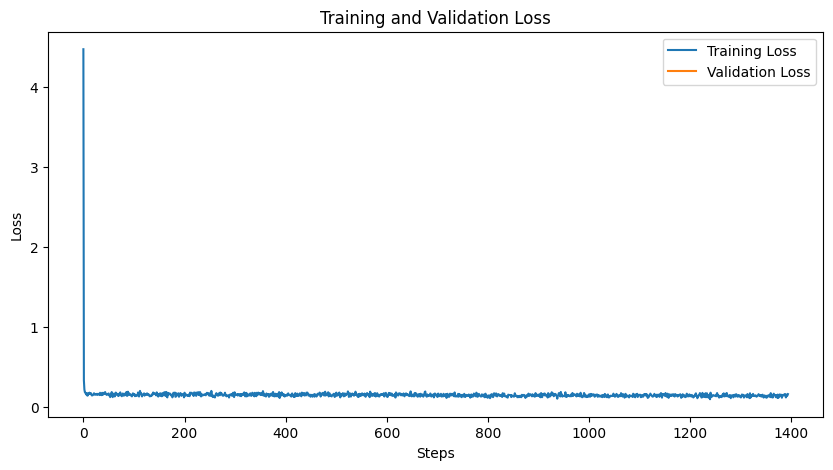

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(logging_callback.training_loss, label='Training Loss')
plt.plot(logging_callback.validation_loss, label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained("./fine_tuned_chatgpt")
model = GPT2LMHeadModel.from_pretrained("./fine_tuned_chatgpt")

# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

while True:
    # Get user input
    user_input = input("You: ")

    # Tokenize user input
    input_ids = tokenizer.encode(user_input, return_tensors="pt").to(device)

    # Generate response
    output = model.generate(input_ids, max_length=50, pad_token_id=tokenizer.eos_token_id)

    # Decode and print response
    response = tokenizer.decode(output[0], skip_special_tokens=True)
    print("Bot:", response)

You: hi
Bot: hi, I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry
You: how are you
Bot: how are you? I'm fine.
You: whats your favorite thing to do
Bot: whats your favorite thing to do? I'm gonna go to the movies.
You: IM HUNGRY
Bot: IM HUNGRY!  I'm not hungry.  I'm just hungry.  I'm hungry.  I'm hungry.  I'm hungry.  I'm hungry.  I'm hungry.  I'm hungry.  I'm
You: do you feel good
Bot: do you feel good? I feel good.
You: whats your sex
Bot: whats your sex? I don't know.
You: want to have sex
Bot: want to have sex with me? No, I'm not interested in sex.
You: WORMS
Bot: WORMS.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I'm sorry.  I
You: whats your favorite nickname
Bot: whats your favorite nickname? "The One Who's the Boss."
You: are you cool
Bot: are you cool? I'm cool.
